In [4]:
import torch
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as f
import matplotlib.pyplot as plt

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


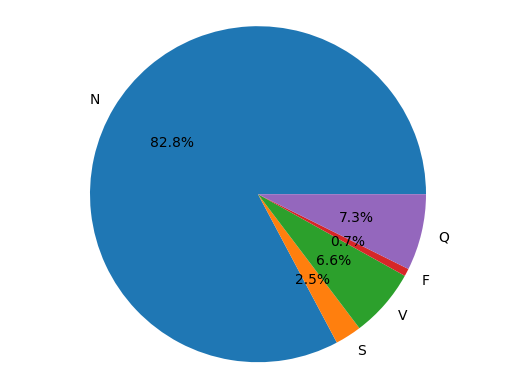

In [6]:
mit_train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
mit_train = mit_train.values
mit_labels = mit_train[:,-1]

# Data for the pie chart
sizes = [len(np.where(mit_labels==0)[0])/mit_train.__len__(), #0 proportion
         len(np.where(mit_labels==1)[0])/mit_train.__len__(), #1 proportion
         len(np.where(mit_labels==2)[0])/mit_train.__len__(), #2 proportion
         len(np.where(mit_labels==3)[0])/mit_train.__len__(), #3 proportion
         len(np.where(mit_labels==4)[0])/mit_train.__len__()] #4 proportion
        
labels = ['N', 'S', 'V', 'F', 'Q']  # Labels for each wedge

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Set aspect ratio to be equal so that pie is drawn as a circle
plt.axis('equal')

# Display the chart
# plt.show()
plt.savefig('/kaggle/working/dist0.jpg', dpi=400)

In [8]:
class MitData:
    def __init__(self, csv_path, drop):
        df = pd.read_csv(csv_path, header=None)
        df = df.values
        df = df[drop:, :]
        self.labels = df[:, -1]
        self.datas = df[:, :-1]
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = torch.LongTensor([self.labels[idx]])
        data = torch.Tensor(self.datas[idx]).unsqueeze(0)
        return data, label

In [9]:
mit_test = MitData('/kaggle/input/heartbeat/mitbih_test.csv', 16500)
mit_train = MitData('/kaggle/input/heartbeat/mitbih_train.csv', 67000)

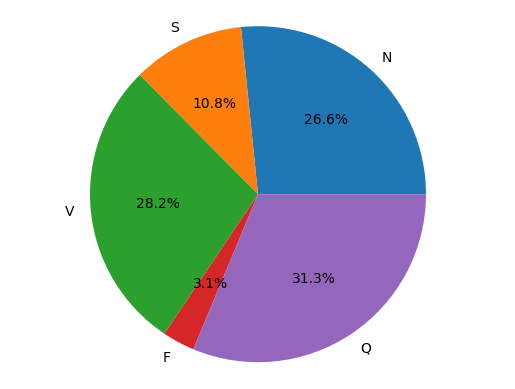

In [10]:
# Data for the pie chart
sizes = [len(np.where(mit_train.labels==0)[0])/mit_train.__len__(), #0 proportion
         len(np.where(mit_train.labels==1)[0])/mit_train.__len__(), #1 proportion
         len(np.where(mit_train.labels==2)[0])/mit_train.__len__(), #2 proportion
         len(np.where(mit_train.labels==3)[0])/mit_train.__len__(), #3 proportion
         len(np.where(mit_train.labels==4)[0])/mit_train.__len__()] #4 proportion
        
labels = ['N', 'S', 'V', 'F', 'Q']  # Labels for each wedge

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Set aspect ratio to be equal so that pie is drawn as a circle
plt.axis('equal')

# Display the chart
# plt.show()
plt.savefig('/kaggle/working/dist.jpg', dpi=400)

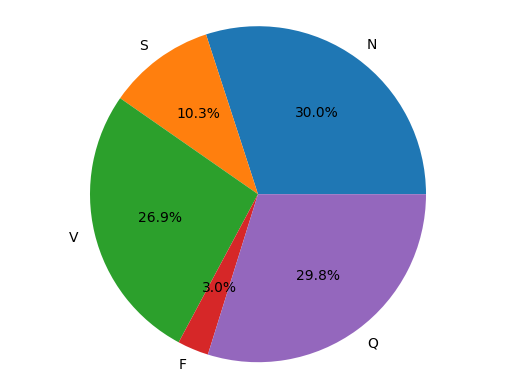

In [11]:
# Data for the pie chart
sizes = [len(np.where(mit_test.labels==0)[0])/mit_test.__len__(), #0 proportion
         len(np.where(mit_test.labels==1)[0])/mit_test.__len__(), #1 proportion
         len(np.where(mit_test.labels==2)[0])/mit_test.__len__(), #2 proportion
         len(np.where(mit_test.labels==3)[0])/mit_test.__len__(), #3 proportion
         len(np.where(mit_test.labels==4)[0])/mit_test.__len__()] #4 proportion
        
labels = ['N', 'S', 'V', 'F', 'Q']  # Labels for each wedge

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Set aspect ratio to be equal so that pie is drawn as a circle
plt.axis('equal')

# Display the chart
plt.show()

In [14]:
class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(32, 32, 5, padding='same')
        self.conv2 = nn.Conv1d(32, 32, 5, padding='same')
        self.pool = nn.MaxPool1d(5, 2)
        
    def forward(self, x):
        output = f.relu(self.conv1(x))
        output = self.conv2(output)
        output = f.relu(output+x)
        output = self.pool(output)
        return output

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv1d(1, 32, 5, padding='same') 
        self.res = nn.Sequential(
            ResBlock(),
            ResBlock(),
            ResBlock(),
            ResBlock(),
            ResBlock()
        )
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 5)
        
    def forward(self, x):
        output = self.conv(x)
        output = self.res(output)
        output = nn.Flatten()(output)
        output = f.relu(self.fc1(output))
        output = f.softmax(self.fc2(output))
        return output

In [16]:
mit_model = Net().to(device)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mit_model.parameters(), lr=1e-3)

In [18]:
BATCH = 64
EPOCH = 50

In [19]:
generator1 = torch.Generator().manual_seed(42)
mit_train, mit_val = torch.utils.data.random_split(mit_train, [0.8, 0.2], generator=generator1)

mit_test_loader = DataLoader(mit_test, batch_size=1)
mit_train_loader = DataLoader(mit_train, batch_size=BATCH, shuffle=True)
mit_val_loader = DataLoader(mit_val, batch_size=BATCH, shuffle=True)

In [20]:
def save_checkpoint(state, is_best, epoch):
    torch.save(state[f'state_dict'], f'/kaggle/working/{epoch}_last.pth')
    if is_best:
        print('Found best')
        torch.save(state[f'state_dict'], f'/kaggle/working/{epoch}_best.pth')

In [21]:
from tqdm.notebook import tqdm
import pandas as pd

def train(model, epoch, train_dataloader, val_dataloader, optimizer, loss_fn):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-9,verbose=True)
    best_acc = 0
    result = {'epoch':[] ,'train_loss_total':[], "val_loss_total":[], 'acc_total':[]}

    for e in range(EPOCH):
        # Training loop
        print(f"Epoch {e+1}")
        result['epoch'].append(e+1)
        print('Train-----')
        loss_epoch = 0
        model.train()

        for batch_data, batch_labels in tqdm(train_dataloader):
            batch_data = batch_data.to(device)

            # Forward pass
            label = batch_labels.to(device).squeeze()
            output = model(batch_data)

            # Optim
            optimizer.zero_grad()
            loss = loss_fn(output, label)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()


        # Combined loss
        loss_epoch /= len(train_dataloader)
        result['train_loss_total'].append(loss_epoch)

        print('Loss: ', loss_epoch)

        # Vaidating
        size = len(val_dataloader.dataset)
        num_batches = len(val_dataloader)
        model.eval()


        test_loss = 0
        correct = 0
    
        with torch.no_grad():
            print('Val------')
            for X, y in tqdm(val_dataloader):

                X = X.to(device)
                pred = model(X)

                label = y.to(device).squeeze()    

                test_loss += loss_fn(pred, label).item()

                correct += (pred.argmax(1) == label).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        scheduler.step(test_loss)
        
        result['val_loss_total'].append(test_loss)
        result['acc_total'].append(correct)
        
        # remember best acc@ and save checkpoint
        is_best = correct > best_acc
        if is_best:
            print('Good')
        best_acc = max(correct, best_acc)
        save_checkpoint({
            f'state_dict': model.state_dict(),
        }, is_best, epoch)
        
        

        print(f"""Val Error:
        Accuracy: {(100*correct)}%
        Avg loss: {test_loss}
        """)
    r = pd.DataFrame(result)
    r.to_csv(f'/kaggle/working/result.csv')
    return result

In [22]:
mit_result = train(mit_model, EPOCH, mit_train_loader, mit_val_loader, optimizer, loss_fn)

Epoch 1
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

/tmp/ipykernel_34/3025429118.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = f.softmax(self.fc2(output))


Loss:  1.2867134795578536
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 74.64720194647202%
        Avg loss: 1.160183389370258
        
Epoch 2
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.1417915723667071
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 79.51338199513383%
        Avg loss: 1.108808656839224
        
Epoch 3
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.1111019856734963
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 79.56204379562044%
        Avg loss: 1.1088375550050003
        
Epoch 4
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.1013042173033094
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 80.90024330900243%
        Avg loss: 1.094368030474736
        
Epoch 5
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0947936638783853
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 81.84914841849148%
        Avg loss: 1.0858806646787202
        
Epoch 6
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0876253182322135
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 82.11678832116789%
        Avg loss: 1.0810361944712126
        
Epoch 7
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.083327051962396
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 82.1411192214112%
        Avg loss: 1.0818081360596876
        
Epoch 8
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0827556375399638
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 82.36009732360098%
        Avg loss: 1.0804795852074256
        
Epoch 9
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0851625292217686
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 82.99270072992701%
        Avg loss: 1.0739394334646373
        
Epoch 10
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0765725402052764
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 83.04136253041362%
        Avg loss: 1.072276808665349
        
Epoch 11
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0696491174660767
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 85.45012165450122%
        Avg loss: 1.0473904059483454
        
Epoch 12
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0312444767135591
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 88.56447688564477%
        Avg loss: 1.0174372104498057
        
Epoch 13
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0298784488833832
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 87.95620437956204%
        Avg loss: 1.0232709132708036
        
Epoch 14
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.02928732410943
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 88.85644768856447%
        Avg loss: 1.0161636352539063
        
Epoch 15
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0218916461161602
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 88.51581508515815%
        Avg loss: 1.0208566803198593
        
Epoch 16
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0167292312425398
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 88.56447688564477%
        Avg loss: 1.018207155741178
        
Epoch 17
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0153522164441269
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.
Val Error:
        Accuracy: 88.1021897810219%
        Avg loss: 1.025139278631944
        
Epoch 18
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0109147172029844
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 89.65936739659367%
        Avg loss: 1.0063755741486182
        
Epoch 19
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0055660324801732
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0052325101999136
        
Epoch 20
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0037090068661285
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 89.87834549878345%
        Avg loss: 1.0056417630268977
        
Epoch 21
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0030431777586732
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 89.90267639902676%
        Avg loss: 1.0037536666943476
        
Epoch 22
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.002192778809989
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.87834549878345%
        Avg loss: 1.0048005021535433
        
Epoch 23
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0018502837952936
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.82968369829683%
        Avg loss: 1.0046787821329557
        
Epoch 24
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0010956099061186
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 1.0000e-05.
Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0048182487487793
        
Epoch 25
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  1.0001270337327446
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Good
Found best
Val Error:
        Accuracy: 89.92700729927007%
        Avg loss: 1.0038433074951172
        
Epoch 26
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9998864049113678
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.90267639902676%
        Avg loss: 1.005473585312183
        
Epoch 27
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9997703133853957
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 1.0000e-06.
Val Error:
        Accuracy: 89.87834549878345%
        Avg loss: 1.004580951653994
        
Epoch 28
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996685851872663
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.87834549878345%
        Avg loss: 1.0047471835063053
        
Epoch 29
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996539943413048
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0046441646722646
        
Epoch 30
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996562801910281
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.0000e-07.
Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0037320540501522
        
Epoch 31
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996096037241271
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0045339685219985
        
Epoch 32
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996207938583909
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0045897859793442
        
Epoch 33
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996197550677139
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 1.0000e-08.
Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.003730898637038
        
Epoch 34
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996225669226294
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0037312094981854
        
Epoch 35
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996261262708137
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0037309674116281
        
Epoch 36
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996129023889623
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0062536982389596
        
Epoch 37
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996260098446204
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.00458952830388
        
Epoch 38
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996018191719798
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0045897300426776
        
Epoch 39
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996259258878835
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0048303842544555
        
Epoch 40
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996333588422041
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0037310224313003
        
Epoch 41
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996095925917421
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0048496732344994
        
Epoch 42
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996174970489532
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0037313901461087
        
Epoch 43
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996053504572768
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0062849732545707
        
Epoch 44
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996414875705882
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0053722519140977
        
Epoch 45
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996050433889901
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.006282497369326
        
Epoch 46
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996331415287716
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0039025435080895
        
Epoch 47
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996128124021835
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0054460681401767
        
Epoch 48
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996046391442592
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0037311810713547
        
Epoch 49
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996204188361706
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0062320067332342
        
Epoch 50
Train-----


  0%|          | 0/257 [00:00<?, ?it/s]

Loss:  0.9996165656394068
Val------


  0%|          | 0/65 [00:00<?, ?it/s]

Val Error:
        Accuracy: 89.85401459854015%
        Avg loss: 1.0045657102878278
        


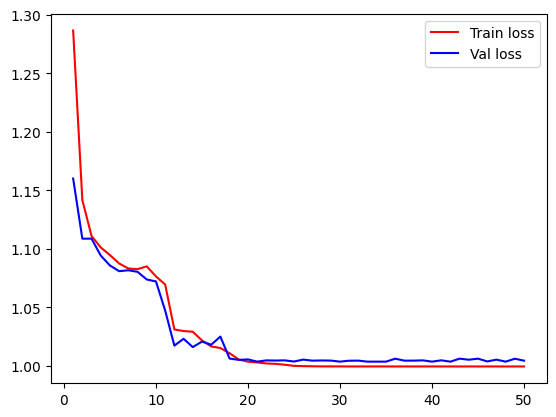

In [23]:
result = pd.read_csv('/kaggle/working/result.csv')
plt.plot(result['epoch'], result['train_loss_total'], color='red', label='Train loss')
plt.plot(result['epoch'], result['val_loss_total'], color='blue', label='Val loss')
plt.legend()
plt.show()

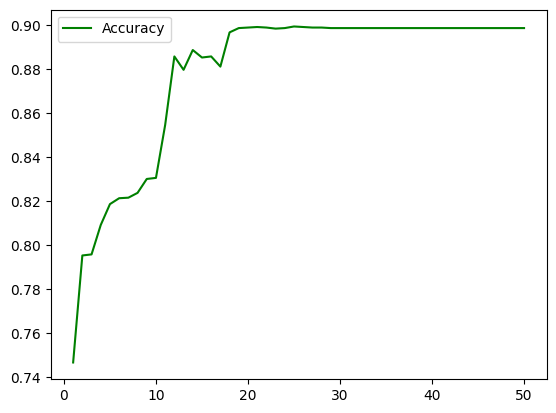

In [24]:
plt.plot(result['epoch'], result['acc_total'], color='g', label='Accuracy')
plt.legend()
plt.show()

In [26]:
from tqdm import tqdm
mit_model.eval()
size = len(mit_test_loader.dataset)
num_batches = len(mit_test_loader)
test_loss = 0
correct = 0
with torch.no_grad():
    print('Test------')
    for X, y in tqdm(mit_test_loader):

        X = X.to(device)
        pred = mit_model(X)

        label = y.to(device).squeeze(1)   

        test_loss += loss_fn(pred, label).item()

        correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    print(f"""Test Error:
    Accuracy: {(100*correct)}%
    Avg loss: {test_loss}
    """)

Test------


  0%|          | 0/5392 [00:00<?, ?it/s]/tmp/ipykernel_34/3025429118.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = f.softmax(self.fc2(output))
100%|██████████| 5392/5392 [00:11<00:00, 458.88it/s]

Test Error:
    Accuracy: 89.61424332344214%
    Avg loss: 1.0074162485094558
    


In [27]:
def eval(model, test_loader):
    model.eval()
    soft = nn.Softmax(dim=1)
    test_loss = 0
    correct = 0
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    all_list = {'conf':[], 'pred':[], 'actual':[]}
    fail_list = {'conf':[], 'pred':[], 'actual':[]}
    with torch.no_grad():
        for X, y in tqdm(test_loader):           
            X = X.to(device)
            pred = model(X)

            label = y.to(device).squeeze(1)    

            test_loss += loss_fn(pred, label).item()

            final_pred = pred.argmax(1)
            confidence = soft(pred)

            all_list['conf'].append(confidence.cpu())
            all_list['pred'].append(final_pred.cpu())
            all_list['actual'].append(label.cpu())

            if final_pred == label:
                correct += 1
            else:
                fail_list['pred'].append(final_pred.cpu())
                fail_list['conf'].append(confidence.cpu())
                fail_list['actual'].append(label.cpu())

    #         test_loss /= num_batches
        correct /= size

        print(f"""Test Error:
        Accuracy: {(100*correct)}%
        """)
    return correct, fail_list, all_list

In [66]:
mit_model = Net().to(device)
mit_model.load_state_dict(torch.load('/kaggle/input/50epoch/50_best.pth'))

<All keys matched successfully>

In [67]:
from tqdm import tqdm

In [28]:
correct_mit, fail_mit, all_mit = eval(mit_model, mit_test_loader)

  0%|          | 0/5392 [00:00<?, ?it/s]/tmp/ipykernel_34/3025429118.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = f.softmax(self.fc2(output))
100%|██████████| 5392/5392 [00:12<00:00, 442.98it/s]

Test Error:
        Accuracy: 89.61424332344214%
        


In [29]:
from sklearn import metrics
from torchmetrics.classification import *

def get_metrics(pred, target, conf):
    classes = [0, 1, 2, 3, 4]
    name = ['N', 'S', 'V', 'F', 'Q']
    
    acc = MulticlassAccuracy(num_classes=len(name), average=None)
    preci = MulticlassPrecision(num_classes=len(name), average=None)
    recall = MulticlassRecall(num_classes=len(name), average=None)
    speci = MulticlassSpecificity(num_classes=len(name), average=None)
    f1s = MulticlassF1Score(num_classes=len(name), average=None)
#     confu = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=3, normalize='true')
    roc = MulticlassROC(num_classes=len(name))
    prc = MulticlassPrecisionRecallCurve(num_classes=len(name))
    aucroc = MulticlassAUROC(num_classes=len(name), average=None)
    aucprc = MulticlassAveragePrecision(num_classes=len(name), average=None)
    
#     target = target.squeeze()
    pred = pred.type(torch.float)
#     print(pred.shape, target.shape)
    #Accuracy
    print('Accuracy:', acc(pred, target))
    #Precision
    print('Precision:', preci(pred, target))
    #Recall
    print('Recall:', recall(pred, target))
    #Specificity
    print('Specificity:', speci(pred, target))
    #F1
    print('F1:', f1s(pred, target))    
    
       
    
    cm = metrics.confusion_matrix(target, pred, labels=classes).astype(float)
    row_sum = cm.sum(axis=1).astype(float).reshape(len(name), 1)
    
    cm /= row_sum
#     cm = cm/cm.astype(float).sum(axis=1)
#     cm = cm.round(3)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = name)
    cm_display.plot()
    
#     plt.show()
    plt.savefig(f'/kaggle/working/50_confu.jpg', dpi=400)
#     print(conf.shape)
#     print(target.shape)
    conf = conf.squeeze(1)
#     conf = conf.unsqueeze(-1)
    target = target.squeeze(1)
#     print(conf.shape)
#     print(target.shape)
    #ROC
    # Compute AUC values
    aucroc.update(conf, target.type(torch.int64))
    aucroc_values = aucroc.compute()
    roc.update(conf, target.type(torch.int64))
    fpr, tpr, thresholds = roc.compute()
#     fig2, ax2 = roc.plot(score=True)
    # Plot ROC curve
    fig2, ax2 = plt.subplots()
    for i in range(len(name)):
        ax2.plot(fpr[i], tpr[i], label=f'{name[i]} AUC:{aucroc_values[i]:.3f}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend()
    ax2.grid(True)
#     fig2.show()
    fig2.savefig(f'/kaggle/working/50_ROC.jpg', dpi=400)
    
    #Prc
    # Compute AUC values
    aucprc.update(conf, target.type(torch.int64))
    aucprc_values = aucprc.compute()
    prc.update(conf, target.type(torch.int64))
#     fig_, ax_ = prc.plot(score=True)
#     fig_.show()
    fpr1, tpr1, thresholds1 = prc.compute()

    fig3, ax3 = plt.subplots()
    for i in range(len(name)):
        ax3.plot(fpr1[i], tpr1[i], label=f'{name[i]} AUC:{aucprc_values[i]:.3f}')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision Recall Curve')
    ax3.legend()
    ax3.grid(True)
#     fig3.show()
    fig3.savefig(f'/kaggle/working/50_PRC.jpg', dpi=400)

Accuracy: tensor([0.9648, 0.5018, 0.9717, 0.0000, 0.9857])
Precision: tensor([0.8181, 0.9426, 0.8945, 0.0000, 0.9814])
Recall: tensor([0.9648, 0.5018, 0.9717, 0.0000, 0.9857])
Specificity: tensor([0.9081, 0.9965, 0.9579, 1.0000, 0.9921])
F1: tensor([0.8854, 0.6549, 0.9315, 0.0000, 0.9836])


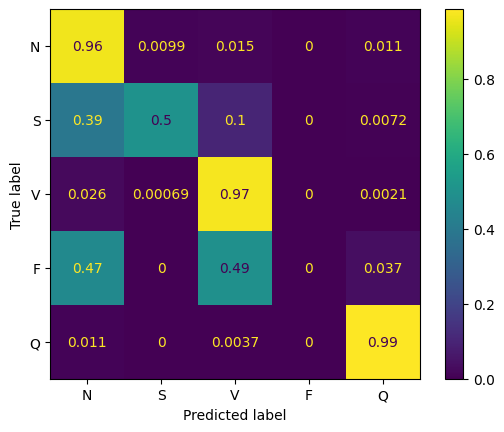

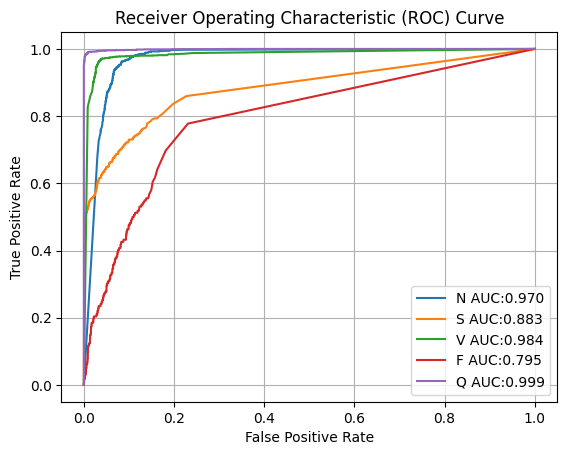

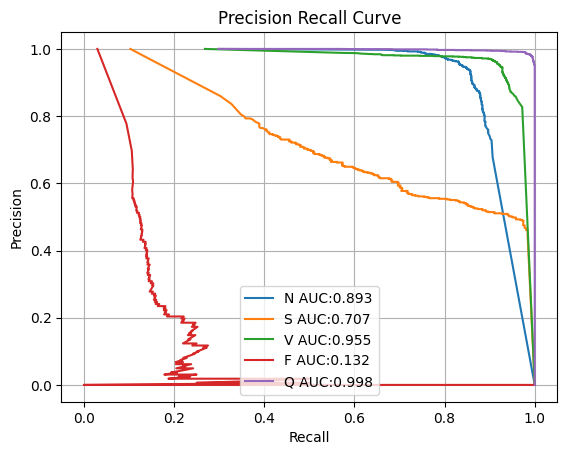

In [30]:
get_metrics(torch.stack(all_mit['pred']), torch.stack(all_mit['actual']), torch.stack(all_mit['conf']))